
**В задании Вам предлагается разобраться с тем, как работает TfidfVectorizer и DictVectorizer, затем обучить и настроить модель линейной регрессии Ridge на данных о публикациях . 

Предскажите, как много звездочек наберет статья, зная только ее текст и время публикации

Необходимо предсказать популярность поста на сайте по содержанию и времени публикации. Как известно, пользователи Хабра могут добавлять статьи к себе в избранное. Общее количество пользователей, которое это сделали отображается у статьи количеством звездочек. Будем считать, что число звездочек, поставленных статье, наиболее хорошо отражает ее популярность.

Более формально, в качестве метрики популярности статьи будем использовать долю статей за последний месяц, у которых количество звездочек меньше чем у текущей статьи. А точнее, доле числа звездочек можно поставить в соответствие квантили стандартного распределения, таким образом получаем числовую характеристику популярности статьи. Популярность статьи 0 означает, что статья получила ровно столько звездочек, сколько в среднем получают статьи. И соответственно чем больше звездочек получила статья по сравнению со средним, тем выше это число.

**Приступим:** импортируем необходимые библиотеки и скачаем данные

In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

#В зависимости от версии sklearn
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import numpy as np
import scipy

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
train_df = pd.read_csv('howpop_train.csv')
test_df  = pd.read_csv('howpop_test.csv')

In [3]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


In [4]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

Убедимся, что данные отсортированы по признаку `published`

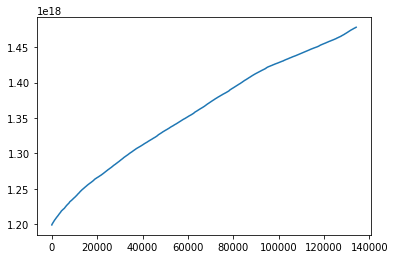

In [5]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

**Чтобы ответить на вопросы 1 и 2, можно использовать [pandas.DataFrame.corr()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html), [pandas.to_datetime()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) и [pandas.Series.value_counts()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html)**

<font color='red'>Вопрос 1.</font> Есть ли в train_df признаки, корреляция между которыми больше 0.9? Обратите внимание, именно различные признаки - корреляция признака с самим собой естественно больше 0.9 :)
- да
- нет!!!!!!!!!!!
- не знаю

                   post_id   polling  content_len  comments      favs  \
post_id           1.000000  0.081628     0.241384 -0.147763  0.089313   
polling           0.081628  1.000000    -0.003337  0.042605  0.006882   
content_len       0.241384 -0.003337     1.000000 -0.023544  0.308194   
comments         -0.147763  0.042605    -0.023544  1.000000  0.164166   
favs              0.089313  0.006882     0.308194  0.164166  1.000000   
views             0.132385  0.025660     0.204101  0.290035  0.634304   
votes_plus       -0.187885 -0.033505     0.068779  0.613961  0.416241   
votes_minus      -0.235594  0.027116    -0.078686  0.457638  0.062877   
views_lognorm    -0.010376 -0.003523     0.246063  0.349568  0.456097   
favs_lognorm     -0.005845 -0.036385     0.356481  0.278942  0.587982   
comments_lognorm -0.001605  0.071417     0.073132  0.662740  0.263239   

                     views  votes_plus  votes_minus  views_lognorm  \
post_id           0.132385   -0.187885    -0.235594  

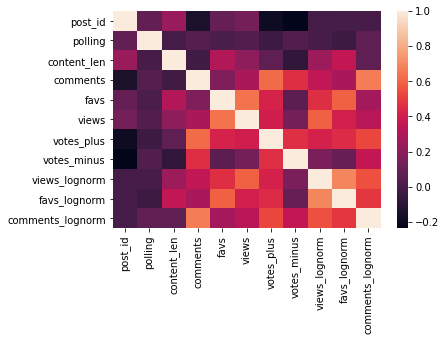

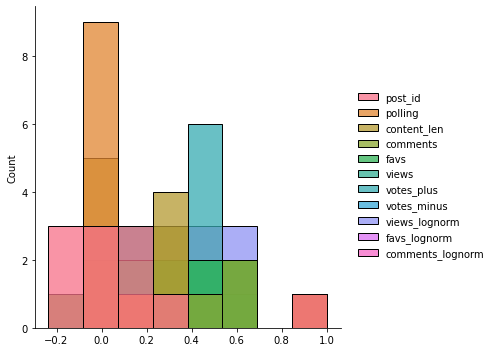

In [6]:
import seaborn as sns

corr = train_df.corr()
print(corr)
sns.heatmap(corr)
sns.displot(corr)
#ответ нет


<font color='red'>Вопрос 2.</font> В каком году было больше всего публикаций? (Рассматриваем train_df)
- 2014
- 2015
- 2016
- 2017

In [11]:
import datetime
a=pd.to_datetime(train_df.published)
b=pd.unique(a)
#train_df.datetime.published()
#pd.unique(train_df.published)
c=pd.to_datetime(train_df.published).value_counts()
#2015

#print(c)
#train_df['year']=train_df.published.map(lambda x: x.year)#получаем данные по году
#yearpublished=pd.DataFrame(data=train_df.groupby('year')['url'].count())
#yearpublished.sort_values('url',ascending=False,inplace=True)
[abs(i) for i in np.array(train_df.corr()).flatten() if (i>0.9)&(i<1)]
train_df.published.apply(lambda ts: pd.to_datetime(ts).year).value_counts()
#print( yearpublished.iloc[0])

2015    23452
2016    16316
2014    16180
2012    15972
2013    15537
2011    15063
2010    13091
2009    10783
2008     7743
Name: published, dtype: int64

## Разбиение на train/valid
Используем только признаки 'author', 'flow', 'domain' и 'title'

In [12]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [13]:
len(train_df),train_size

(134137, 93895)

In [14]:
X, y = train_df.loc[:4, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной
X_test = train_df.loc[:, features]


In [15]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]
print(X_valid)

Empty DataFrame
Columns: [author, flow, domain, title]
Index: []


## Применение TfidfVectorizer

**TF-IDF** (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе, и обратно пропорционален частоте употребления слова в других документах коллекции. [Подробнее в источнике](https://ru.wikipedia.org/wiki/TF-IDF)

TfidfVectorizer преобразует тексты в матрицу TF-IDF признаков.

**Основные параметры TfidfVectorizer в sklearn:**
- **min_df** - при построении словаря слова, которые встречаются *реже*, чем указанное значение, игнорируются
- **max_df** - при построении словаря слова, которые встречаются *чаще*, чем указанное значение, игнорируются
- **analyzer** - определяет, строятся ли признаки по словам или по символам (буквам)
- **ngram_range** - определяет, формируются ли признаки только из отдельных слов или из нескольких слов (в случае с analyzer='char' задает количество символов). Например, если указать analyzer='word' и ngram_range=(1,3),то признаки будут формироваться из отдельных слов, из пар слов и из троек слов.
- **stop_words** - слова, которые игнорируются при построении матрицы

Более подробно с параметрами можно ознакомиться в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

**Инициализируйте TfidfVectorizer с параметрами min_df=3, max_df=0.3 и ngram_range=(1, 3).<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 3.</font> Какой размер у полученного словаря?
- 43789
- 50624 50624!!
- 93895
- 74378

In [18]:
X, y = train_df.loc[:4, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной
X_test = train_df.loc[:, features]
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]
def getTfid(analyser):
    tfid=TfidfVectorizer(min_df=0.3, max_df=3, ngram_range=(1, 9))
    if analyser: tfid=TfidfVectorizer(analyzer='char')
    tfid.fit_transform(X_train['title'])
    #tfid.transform(X_valid['title'])
    tfid.transform(X_test['title'])
    return tfid

tfid=getTfid(False)
vocabulary=tfid.vocabulary_
print(u'Размер словаря: ',len(vocabulary))
print(vocabulary)
vectorizer = TfidfVectorizer()
B = vectorizer.fit_transform(X_train['title'])
#vectorizer.transform(X_valid['title'])
vectorizer.transform(X_test['title'])
print(vectorizer.get_feature_names())

Размер словаря:  28
{'сумасшедшие': 15, 'яйца': 22, 'или': 3, 'сервис': 11, 'для': 0, 'отслеживания': 8, 'посетителей': 10, 'сумасшедшие яйца': 16, 'яйца или': 23, 'или сервис': 4, 'сервис для': 12, 'для отслеживания': 1, 'отслеживания посетителей': 9, 'сумасшедшие яйца или': 17, 'яйца или сервис': 24, 'или сервис для': 5, 'сервис для отслеживания': 13, 'для отслеживания посетителей': 2, 'сумасшедшие яйца или сервис': 18, 'яйца или сервис для': 25, 'или сервис для отслеживания': 6, 'сервис для отслеживания посетителей': 14, 'сумасшедшие яйца или сервис для': 19, 'яйца или сервис для отслеживания': 26, 'или сервис для отслеживания посетителей': 7, 'сумасшедшие яйца или сервис для отслеживания': 20, 'яйца или сервис для отслеживания посетителей': 27, 'сумасшедшие яйца или сервис для отслеживания посетителей': 21}
['iphone', 'wordpress', 'блоггерам', 'для', 'или', 'мне', 'не', 'новогодний', 'нравится', 'отрисовка', 'отслеживания', 'подарок', 'посетителей', 'почему', 'сглаживание', 'сервис

In [19]:
#Можно посмотреть словарь в виде {'термин': индекс признака,...}
vectorizer_title.vocabulary_

AttributeError: 'TfidfVectorizer' object has no attribute 'vocabulary_'

In [ ]:
#ваш код здесь
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vect = TfidfVectorizer()
tfidf_matrix = vect.fit_transform(documents)
df = pd.DataFrame(tfidf_matrix.toarray(), columns = vect.get_feature_names())
print(df)

<font color='red'>Вопрос 4.</font> Какой индекс у слова 'python'?
- 1
- 10
- 9065 9065 9065
- 15679

In [22]:
print(vocabulary['яйца'])

#vectorizer_title.vocabulary_['python']

22


**Инициализируйте TfidfVectorizer, указав analyzer='char'.<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 5.</font> Какой размер у полученного словаря?
- 218 218 218
- 510
- 125
- 981

In [24]:
# feats = ['author', 'flow', 'domain']


# vectorizer_title=TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1, 3))
# X_train_title=vectorizer_title.fit_transform(X_train['title'])
# X_valid_title=vectorizer_title.transform(X_valid['title'])
# X_test_title=vectorizer_title.transform(X_test['title'])


# vectorizer_title_ch=TfidfVectorizer(analyzer='char')
# X_train_title_ch=vectorizer_title.fit_transform(X_train['title'])
# X_valid_title_ch =vectorizer_title.transform(X_valid['title'])
# X_test_title_ch=vectorizer_title.transform(X_test['title']))


ValueError: Found array with 0 sample(s) (shape=(0, 41)) while a minimum of 1 is required.

In [ ]:
#Здесь так же можно посмотреть словарь
#Заметьте насколько отличаются словари для TfidfVectorizer с analyzer='word' и analyzer='char'
vectorizer_title_ch.vocabulary_

In [ ]:
#ваш код здесь

## Работа с категориальными признаками

Для обработки категориальных признаков 'author', 'flow', 'domain' мы будем использовать DictVectorizer из sklearn.

In [25]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


Рассмотрим как он работает на примере первых пяти строк

In [26]:
#сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [27]:
#Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
#а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'},
 1: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 2: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 3: {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'},
 4: {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}}

In [28]:
#В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
#поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [29]:
#В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [30]:
#Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

array([[0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0.]])

In [31]:
#В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
#Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(5, 9)

Посмотрим сколько уникальных значений в каждой колонке.<br />
Суммарно их 9 - столько же, сколько и колонок. Это объясняется тем, что для категориальных признаков со строковыми значениями DictVectorizer делает кодирование бинарными признаками - каждому уникальному значению признака соответствует один новый бинарный признак, который равен 1 только в том случае, если в исходной матрице этот признак принимает значение, которому соответствует эта колонка новой матрицы.

In [32]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


Также можно посмотреть что означает каждая колонка полученной матрицы

In [33]:
#например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

**Инициализируйте DictVectorizer с параметрами по умолчанию.<br />
Примените метод fit_transform к признакам 'author', 'flow', 'domain' X_train и метод transform к тем же признакам X_valid и X_test**

In [37]:
vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train.ix[:, feats].fillna('-').T.to_dict().values())
X_valid_feats = vectorizer_feats.transform(X_valid.ix[:, feats].fillna('-').T.to_dict().values())
X_test_feats = vectorizer_feats.transform(X_test.ix[:, feats].fillna('-').T.to_dict().values())

TypeError: '(slice(None, None, None), ['author', 'flow', 'domain'])' is an invalid key

In [ ]:
X_train_feats.shape

Соединим все полученные матрицы при помощи scipy.sparse.hstack()

In [ ]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

## Обучение модели

Далее будем использовать Ridge, линейную модель с l2-регуляризацией.
[Документация](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

Основной параметр Ridge - **alpha, коэффициент регуляризации**. Регуляризация используется для улучшения обобщающей способности модели - прибавляя к функционалу потерь сумму квадратов весов, умноженную на коэффициент регуляризации (та самая alpha), мы штрафуем модель за слишком большие значения весов и не позволяем ей переобучаться. Чем больше этот коээфициент, тем сильнее эффект.

**Обучите две модели на X_train_new, y_train, задав в первой alpha=0.1 и random_state = 1, а во второй alpha=1.0 и random_state = 1**

**Рассчитайте среднеквадратичную ошибку каждой модели (mean_squared_error). Сравните значения ошибки на обучающей и тестовой выборках и ответьте на вопросы.**

<font color='red'>Вопрос 6.</font> Выберите верные утверждения:
- обе модели показывают одинаковый результат (среднеквадратичная ошибка отличается не больше чем на тысячные), регуляризация ничего не меняет
- при alpha=0.1 модель переобучается при alpha=0.1 модель переобучается
- среднеквадратичная ошибка первой модели на тесте меньше
- при alpha=1.0 у модели обощающая способность лучше, чем у при alpha=0.1 при alpha=1.0 у модели обощающая способность лучше, чем у при alpha=0.1

In [38]:

model1=Ridge(alpha=0.1, random_state = 1)
model1.fit(X_train_new,y_train)


NameError: name 'X_train_new' is not defined

In [ ]:
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds1))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds1))

In [ ]:
model2=Ridge(alpha=1.0, random_state = 1)
model2.fit(X_train_new,y_train)

In [ ]:
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print('alpha=1.0. Ошибка на трейне',mean_squared_error(y_train, train_preds2))
print('alpha=1.0. Ошибка на тесте',mean_squared_error(y_valid, valid_preds2))

## Baseline

**Теперь попытаемся получить бейзлайн для соревования - используйте Ridge с параметрами по умолчанию и обучите модель на всех данных - соедините X_train_new X_valid_new (используйте scipy.sparse.vstack()), а целевой переменной будет y.**

In [ ]:
%%time

model = Ridge()

model.fit(scipy.sparse.vstack([X_train_new, X_valid_new]), y) #обучаем на всех данных
test_preds = model.predict(X_test_new)

In [21]:
sample_submission = pd.read_csv('sample_submission.csv', index_col='url')

In [22]:
sample_submission.head()

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.323588
https://habrahabr.ru/company/plesk/blog/313732/,0.560105
https://habrahabr.ru/company/etagi/blog/314000/,0.667039
https://habrahabr.ru/company/knopka/blog/314030/,0.149563
https://geektimes.ru/company/audiomania/blog/282058/,0.670754


In [ ]:
ridge_submission = sample_submission.copy()
ridge_submission['favs_lognorm'] = test_preds
ridge_submission.to_csv('ridge_baseline.csv') #а вот и бейзлайн